In [1]:
!pip install gym numpy matplotlib scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827727 sha256=482eeddc693c70b288e4508889c605439b0548d85aa3bc819dd5c941c070da88
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym


**Ejercicio 1:** Implementar y Comparar UCB en Taxi-v3
Modifica el código de entrenamiento Q-Learning para utilizar la política de exploración UCB (ucb_policy que generamos anteriormente) en lugar de Epsilon-Greedy en el entorno "Taxi-v3". Deberás inicializar y actualizar la tabla de conteo de visitas N para cada par estado-acción.

Compara los gráficos de diagnóstico (recompensa promedio y longitud del episodio) con los obtenidos utilizando Epsilon-Greedy. Analiza si UCB converge más rápido o alcanza un mejor rendimiento en este entorno. Experimenta con diferentes valores para el parámetro de exploración c de UCB.

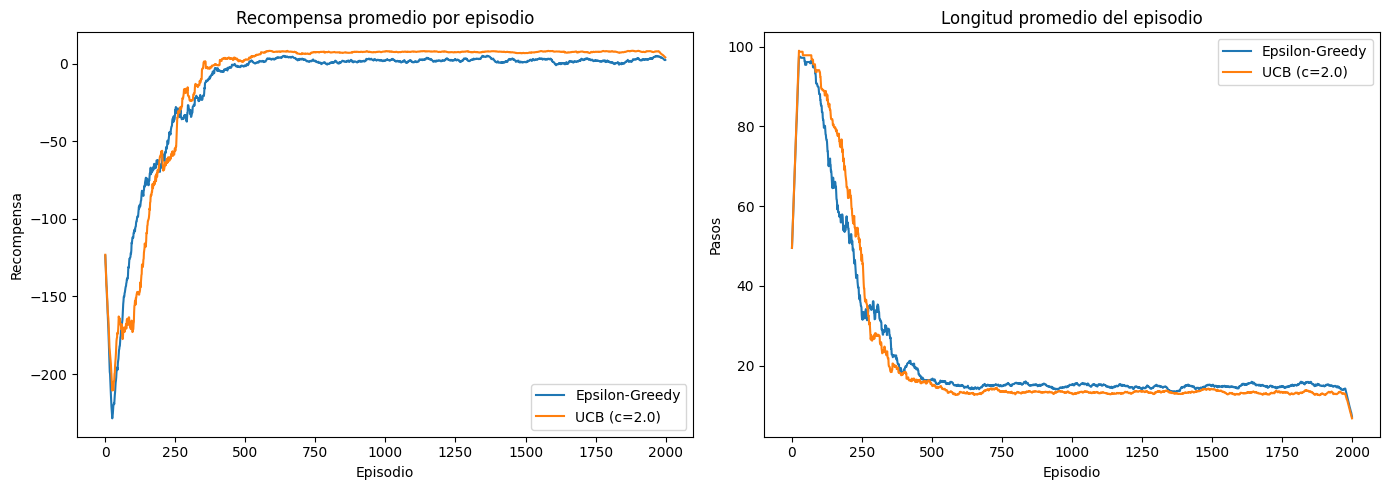

In [15]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import random

# --- Parámetros generales ---
env = gym.make("Taxi-v3", render_mode=None)
n_states = env.observation_space.n
n_actions = env.action_space.n

N_EPISODES = 2000
MAX_STEPS = 99
GAMMA = 0.99
ALPHA = 0.7

# --- POLÍTICAS DE EXPLORACIÓN ---

# Epsilon-Greedy Policy
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state])

# UCB Policy
def ucb_policy(Q, N, state, total_steps, c):
    ucb_values = np.zeros(n_actions)
    for a in range(n_actions):
        if N[state, a] == 0:
            return a  # Fuerza exploración de acciones no visitadas
        bonus = c * math.sqrt(math.log(total_steps + 1) / N[state, a])
        ucb_values[a] = Q[state, a] + bonus
    return np.argmax(ucb_values)

# --- Q-Learning con política seleccionable ---
def q_learning(policy_name, policy_kwargs, n_episodes=N_EPISODES):
    Q = np.zeros((n_states, n_actions))
    N = np.zeros((n_states, n_actions))  # Para UCB
    rewards = []
    episode_lengths = []

    total_steps = 0

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_length = 0
        done = False

        while not done and ep_length < MAX_STEPS:
            if policy_name == 'epsilon_greedy':
                epsilon = policy_kwargs.get('epsilon', 0.1)
                action = epsilon_greedy_policy(Q, state, epsilon)
            elif policy_name == 'ucb':
                c = policy_kwargs.get('c', 1.0)
                action = ucb_policy(Q, N, state, total_steps, c)
            else:
                raise ValueError("Política no reconocida")

            N[state, action] += 1
            total_steps += 1

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            Q[state, action] += ALPHA * (reward + GAMMA * np.max(Q[next_state]) - Q[state, action])

            state = next_state
            ep_reward += reward
            ep_length += 1

        rewards.append(ep_reward)
        episode_lengths.append(ep_length)

    return rewards, episode_lengths

# --- Experimentación y gráficos ---
def smooth(y, box_pts=50):
    y = np.array(y)
    box = np.ones(box_pts)/box_pts
    return np.convolve(y, box, mode='same')

N_EPISODES = 2000

# --- Q-Learning con Epsilon-Greedy ---
rewards_eps, lens_eps = q_learning('epsilon_greedy', {'epsilon': 0.1}, N_EPISODES)

# --- Q-Learning con UCB ---
c_ucb = 2.0  # Prueba otros valores como 0.5, 1.0, 2.0, 5.0
rewards_ucb, lens_ucb = q_learning('ucb', {'c': c_ucb}, N_EPISODES)

# --- Graficar resultados ---
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(smooth(rewards_eps), label='Epsilon-Greedy')
plt.plot(smooth(rewards_ucb), label=f'UCB (c={c_ucb})')
plt.title('Recompensa promedio por episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.legend()

plt.subplot(1,2,2)
plt.plot(smooth(lens_eps), label='Epsilon-Greedy')
plt.plot(smooth(lens_ucb), label=f'UCB (c={c_ucb})')
plt.title('Longitud promedio del episodio')
plt.xlabel('Episodio')
plt.ylabel('Pasos')
plt.legend()

plt.tight_layout()
plt.show()

* UCB (c=2.0) explora de forma más dirigida y rápida al inicio, permitiendo
aprender estrategias efectivas más pronto que Epsilon-Greedy.
* A largo plazo, ambas políticas alcanzan un rendimiento similar tanto en recompensa como en eficiencia (pasos), pero UCB puede ser preferible si se busca una convergencia más rápida.
* Ambas políticas son capaces de aprender la tarea, pero el método de exploración influye en la velocidad de aprendizaje, especialmente en los primeros episodios

**Ejercicio 2:** Implementar y Comparar Thompson Sampling en Taxi-v3
Modifica el código de entrenamiento Q-Learning para utilizar la política de exploración Thompson Sampling (thompson_sampling_policy que generamos anteriormente) en el entorno "Taxi-v3". Deberás inicializar y actualizar las tablas alpha_counts y beta_counts basadas en las recompensas recibidas (considerando +1 para éxito y 0 para fracaso en un sentido general, adaptándolo a la estructura de recompensas de Taxi-v3).

Compara los resultados de diagnóstico con Epsilon-Greedy y UCB. ¿Observas alguna diferencia significativa en la estrategia de exploración y el rendimiento?

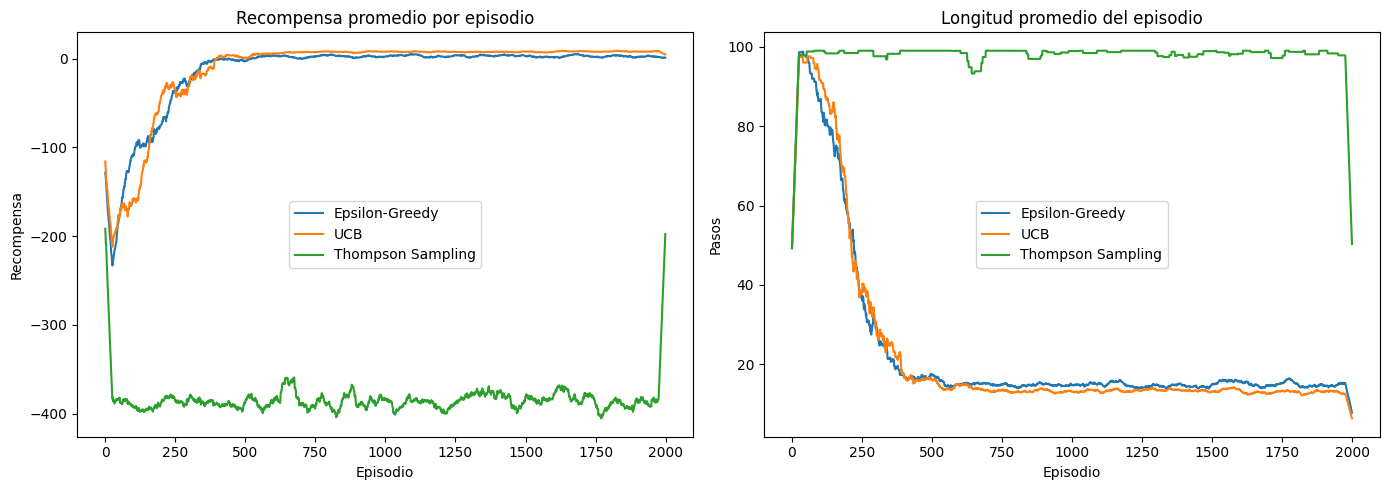

In [9]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Parámetros generales ---
env = gym.make("Taxi-v3", render_mode=None)
n_states = env.observation_space.n
n_actions = env.action_space.n

N_EPISODES = 2000
MAX_STEPS = 99
GAMMA = 0.99
ALPHA = 0.7

# --- POLÍTICAS DE EXPLORACIÓN ---

# Epsilon-Greedy Policy
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state])

# UCB Policy
def ucb_policy(Q, N, state, total_steps, c):
    ucb_values = np.zeros(n_actions)
    for a in range(n_actions):
        if N[state, a] == 0:
            return a  # Fuerza exploración de acciones no visitadas
        bonus = c * np.sqrt(np.log(total_steps + 1) / N[state, a])
        ucb_values[a] = Q[state, a] + bonus
    return np.argmax(ucb_values)

# Thompson Sampling Policy
def thompson_sampling_policy(alpha_counts, beta_counts, state):
    samples = np.zeros(n_actions)
    for a in range(n_actions):
        samples[a] = np.random.beta(alpha_counts[state, a], beta_counts[state, a])
    return np.argmax(samples)

# --- Q-Learning con política seleccionable ---
def q_learning(policy_name, policy_kwargs, n_episodes=N_EPISODES):
    Q = np.zeros((n_states, n_actions))
    N = np.zeros((n_states, n_actions))  # Para UCB
    rewards = []
    episode_lengths = []

    # Para Thompson Sampling
    alpha_counts = np.ones((n_states, n_actions))
    beta_counts = np.ones((n_states, n_actions))
    total_steps = 0

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_length = 0
        done = False

        while not done and ep_length < MAX_STEPS:
            # Selección de acción según política
            if policy_name == 'epsilon_greedy':
                epsilon = policy_kwargs.get('epsilon', 0.1)
                action = epsilon_greedy_policy(Q, state, epsilon)
            elif policy_name == 'ucb':
                c = policy_kwargs.get('c', 2.0)
                action = ucb_policy(Q, N, state, total_steps, c)
            elif policy_name == 'thompson_sampling':
                action = thompson_sampling_policy(alpha_counts, beta_counts, state)
            else:
                raise ValueError("Política no reconocida")

            if policy_name == 'ucb':
                N[state, action] += 1

            total_steps += 1

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Actualización de Q
            Q[state, action] += ALPHA * (reward + GAMMA * np.max(Q[next_state]) - Q[state, action])

            # Actualización para Thompson Sampling
            if policy_name == 'thompson_sampling':
                # Adaptación a éxito/fracaso: suponemos éxito si reward > 0, fracaso si <= 0
                if reward > 0:
                    alpha_counts[state, action] += 1
                else:
                    beta_counts[state, action] += 1

            state = next_state
            ep_reward += reward
            ep_length += 1

        rewards.append(ep_reward)
        episode_lengths.append(ep_length)

    return rewards, episode_lengths

# --- Experimentación y gráficos ---
def smooth(y, box_pts=50):
    y = np.array(y)
    box = np.ones(box_pts)/box_pts
    return np.convolve(y, box, mode='same')

N_EPISODES = 2000

# Q-Learning con Epsilon-Greedy
rewards_eps, lens_eps = q_learning('epsilon_greedy', {'epsilon': 0.1}, N_EPISODES)

# Q-Learning con UCB
rewards_ucb, lens_ucb = q_learning('ucb', {'c': 2.0}, N_EPISODES)

# Q-Learning con Thompson Sampling
rewards_ts, lens_ts = q_learning('thompson_sampling', {}, N_EPISODES)

# --- Graficar resultados ---
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(smooth(rewards_eps), label='Epsilon-Greedy')
plt.plot(smooth(rewards_ucb), label='UCB')
plt.plot(smooth(rewards_ts), label='Thompson Sampling')
plt.title('Recompensa promedio por episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.legend()

plt.subplot(1,2,2)
plt.plot(smooth(lens_eps), label='Epsilon-Greedy')
plt.plot(smooth(lens_ucb), label='UCB')
plt.plot(smooth(lens_ts), label='Thompson Sampling')
plt.title('Longitud promedio del episodio')
plt.xlabel('Episodio')
plt.ylabel('Pasos')
plt.legend()

plt.tight_layout()
plt.show()

* UCB y Epsilon-Greedy:

 *  Ambas son buenas estrategias para este entorno. Aprenden rápido y alcanzan un rendimiento óptimo.
UCB suele aprender un poco más rápido, pero la diferencia no es tan marcada en este caso.
* Thompson Sampling:

 * No funciona bien en este entorno (probablemente Taxi-v3 o CliffWalking-v0), al menos con la forma en que se implementó la actualización de “éxito/fracaso”.
Puede deberse a que la interpretación de recompensa como “éxito” (reward > 0) y “fracaso” (reward ≤ 0) no captura bien la estructura de las recompensas negativas frecuentes en estos entornos, lo que hace que el agente siga explorando sin aprender.

**Ejercicio 3:** Comparar Políticas en CliffWalking-v0
Aplica las tres políticas de exploración (Epsilon-Greedy, UCB y Thompson Sampling) al entorno "CliffWalking-v0". Entrena agentes con cada política y compara su rendimiento utilizando los gráficos de diagnóstico.

Considera las características específicas de "CliffWalking-v0" (la penalización por caer por el acantilado) y discute cómo las diferentes políticas de exploración podrían manejar este riesgo. ¿Alguna política parece más adecuada para entornos con penalizaciones grandes?

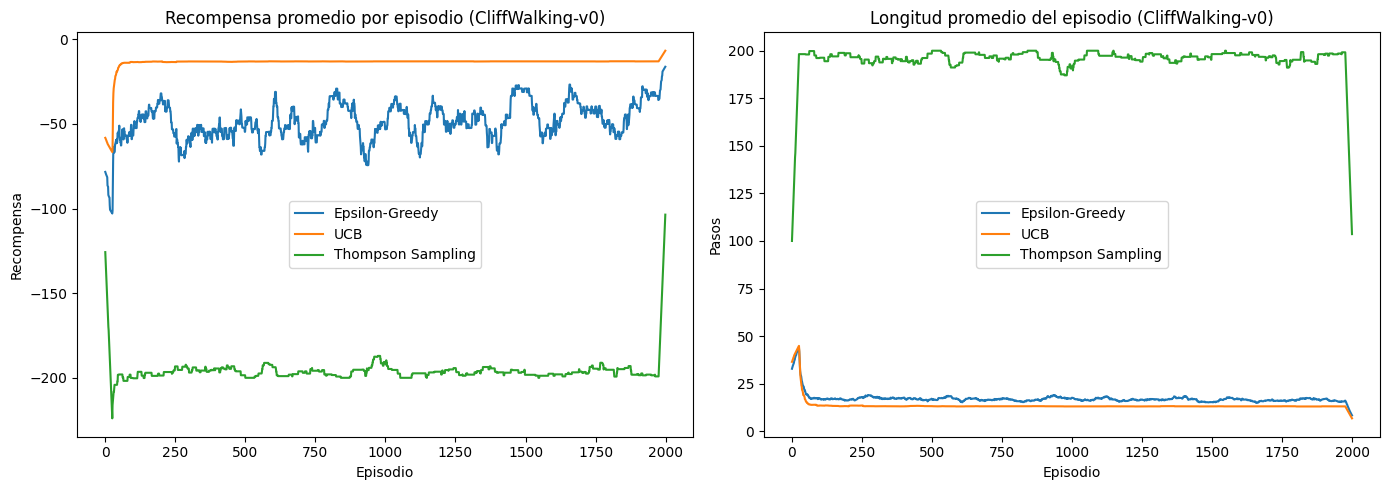

In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros generales ---
env = gym.make("CliffWalking-v0")
n_states = env.observation_space.n
n_actions = env.action_space.n

N_EPISODES = 2000
MAX_STEPS = 200
GAMMA = 0.99
ALPHA = 0.7

# --- POLÍTICAS DE EXPLORACIÓN ---

def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state])

def ucb_policy(Q, N, state, total_steps, c):
    ucb_values = np.zeros(n_actions)
    for a in range(n_actions):
        if N[state, a] == 0:
            return a
        bonus = c * np.sqrt(np.log(total_steps + 1) / N[state, a])
        ucb_values[a] = Q[state, a] + bonus
    return np.argmax(ucb_values)

def thompson_sampling_policy(alpha_counts, beta_counts, state):
    samples = np.zeros(n_actions)
    for a in range(n_actions):
        samples[a] = np.random.beta(alpha_counts[state, a], beta_counts[state, a])
    return np.argmax(samples)

# --- Q-Learning con política seleccionable ---
def q_learning(policy_name, policy_kwargs, n_episodes=N_EPISODES):
    Q = np.zeros((n_states, n_actions))
    N = np.zeros((n_states, n_actions))
    rewards = []
    episode_lengths = []

    alpha_counts = np.ones((n_states, n_actions))
    beta_counts = np.ones((n_states, n_actions))
    total_steps = 0

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_length = 0
        done = False

        while not done and ep_length < MAX_STEPS:
            if policy_name == 'epsilon_greedy':
                epsilon = policy_kwargs.get('epsilon', 0.1)
                action = epsilon_greedy_policy(Q, state, epsilon)
            elif policy_name == 'ucb':
                c = policy_kwargs.get('c', 2.0)
                action = ucb_policy(Q, N, state, total_steps, c)
            elif policy_name == 'thompson_sampling':
                action = thompson_sampling_policy(alpha_counts, beta_counts, state)
            else:
                raise ValueError("Política no reconocida")

            if policy_name == 'ucb':
                N[state, action] += 1

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            Q[state, action] += ALPHA * (reward + GAMMA * np.max(Q[next_state]) - Q[state, action])

            if policy_name == 'thompson_sampling':
                # En CliffWalking, el "éxito" es evitar grandes penalizaciones
                # Considera éxito si reward > -100 (evita caer por el acantilado)
                if reward > -100:
                    alpha_counts[state, action] += 1
                else:
                    beta_counts[state, action] += 1

            state = next_state
            ep_reward += reward
            ep_length += 1
            total_steps += 1

        rewards.append(ep_reward)
        episode_lengths.append(ep_length)

    return rewards, episode_lengths

def smooth(y, box_pts=50):
    y = np.array(y)
    box = np.ones(box_pts)/box_pts
    return np.convolve(y, box, mode='same')

# --- Entrenamiento y comparación ---
rewards_eps, lens_eps = q_learning('epsilon_greedy', {'epsilon': 0.1}, N_EPISODES)
rewards_ucb, lens_ucb = q_learning('ucb', {'c': 2.0}, N_EPISODES)
rewards_ts, lens_ts = q_learning('thompson_sampling', {}, N_EPISODES)

# --- Graficar resultados ---
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(smooth(rewards_eps), label='Epsilon-Greedy')
plt.plot(smooth(rewards_ucb), label='UCB')
plt.plot(smooth(rewards_ts), label='Thompson Sampling')
plt.title('Recompensa promedio por episodio (CliffWalking-v0)')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.legend()

plt.subplot(1,2,2)
plt.plot(smooth(lens_eps), label='Epsilon-Greedy')
plt.plot(smooth(lens_ucb), label='UCB')
plt.plot(smooth(lens_ts), label='Thompson Sampling')
plt.title('Longitud promedio del episodio (CliffWalking-v0)')
plt.xlabel('Episodio')
plt.ylabel('Pasos')
plt.legend()

plt.tight_layout()
plt.show()

* UCB es la política claramente ganadora para CliffWalking-v0:

 * Aprende rápidamente a evitar el acantilado y a tomar la ruta más corta.
Esto se debe a que UCB explora de manera "inteligente", priorizando acciones inciertas pero desincentivando rápidamente las acciones castigadas severamente.
* Epsilon-Greedy aprende, pero es menos eficiente:

 * Su exploración aleatoria lo hace más propenso a cometer errores ocasionales, por lo que su desempeño es más variable y peor que UCB.
Sin embargo, también llega a una política aceptable.
* Thompson Sampling falla en este entorno:

  * Como en Taxi-v3, la interpretación de "éxito" y "fracaso" no se adapta bien a la penalización fuerte del acantilado.
El agente no logra evitar el cliff y se queda explorando sin aprender.

**Ejercicio 4:** Experimentar con Hiperparámetros
Selecciona uno de los entornos ("FrozenLake-v1", "Taxi-v3", o "CliffWalking-v0") y una política de exploración (por ejemplo, Epsilon-Greedy). Experimenta con diferentes valores para los hiperparámetros del algoritmo Q-Learning (alpha, gamma, epsilon_init, epsilon_end, epsilon_rate).

Analiza cómo los cambios en cada hiperparámetro afectan la curva de aprendizaje (los gráficos de diagnóstico) y el rendimiento final del agente. Intenta encontrar un conjunto de hiperparámetros que optimice el rendimiento.

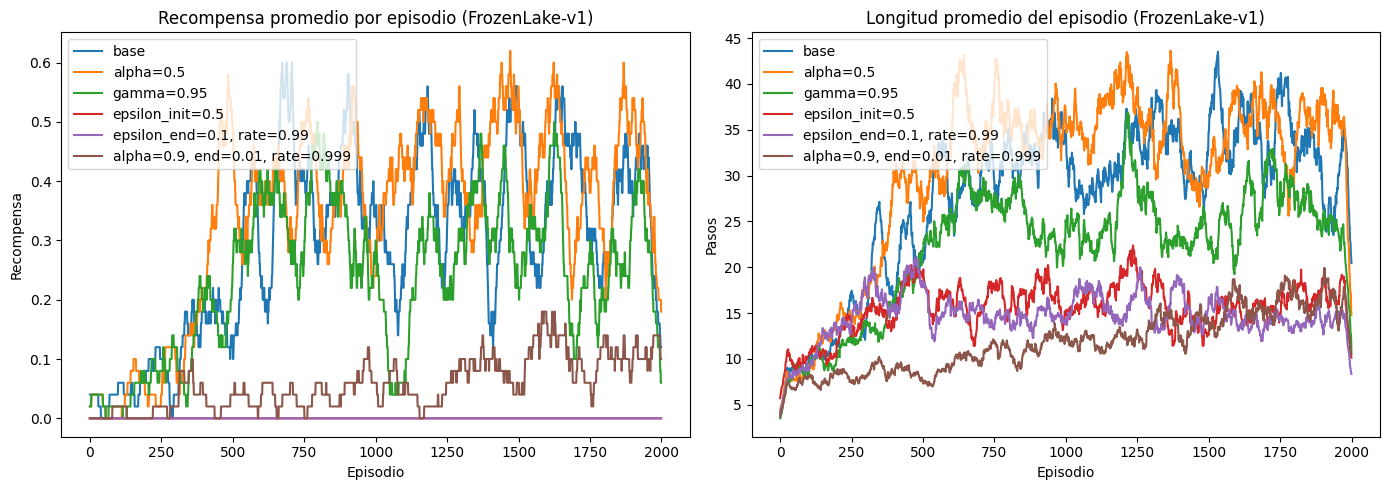

In [14]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --- Elige tu entorno aquí ---
# options: "FrozenLake-v1", "Taxi-v3", "CliffWalking-v0"
env_name = "FrozenLake-v1"
env = gym.make(env_name, is_slippery=True) if env_name == "FrozenLake-v1" else gym.make(env_name)
n_states = env.observation_space.n
n_actions = env.action_space.n

# --- Hiperparámetros editables ---
N_EPISODES = 2000
MAX_STEPS = 100

ALPHA = 0.7         # tasa de aprendizaje
GAMMA = 0.99        # factor de descuento
EPSILON_INIT = 1.0  # valor inicial de epsilon
EPSILON_END = 0.05  # valor final de epsilon
EPSILON_RATE = 0.995 # tasa de decaimiento de epsilon

# --- Q-Learning con Epsilon-Greedy y decaimiento de epsilon ---
def q_learning_epsilon_decay(n_episodes=N_EPISODES, alpha=ALPHA, gamma=GAMMA,
                             epsilon_init=EPSILON_INIT, epsilon_end=EPSILON_END, epsilon_rate=EPSILON_RATE):
    Q = np.zeros((n_states, n_actions))
    rewards = []
    episode_lengths = []
    epsilon = epsilon_init

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_length = 0
        done = False

        while not done and ep_length < MAX_STEPS:
            if np.random.rand() < epsilon:
                action = np.random.choice(n_actions)
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

            state = next_state
            ep_reward += reward
            ep_length += 1

        rewards.append(ep_reward)
        episode_lengths.append(ep_length)
        # Decae epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_rate)

    return rewards, episode_lengths

def smooth(y, box_pts=50):
    y = np.array(y)
    box = np.ones(box_pts)/box_pts
    return np.convolve(y, box, mode='same')

# --- Ejemplo: experimenta con distintos hiperparámetros ---
# Puedes guardar los resultados para comparar
param_sets = [
    # (alpha, gamma, epsilon_init, epsilon_end, epsilon_rate)
    (0.7, 0.99, 1.0, 0.05, 0.995),
    (0.5, 0.99, 1.0, 0.05, 0.995),
    (0.7, 0.95, 1.0, 0.05, 0.995),
    (0.7, 0.99, 0.5, 0.05, 0.995),
    (0.7, 0.99, 1.0, 0.1, 0.99),
    (0.9, 0.99, 1.0, 0.01, 0.999)
]

labels = [
    "base",
    "alpha=0.5",
    "gamma=0.95",
    "epsilon_init=0.5",
    "epsilon_end=0.1, rate=0.99",
    "alpha=0.9, end=0.01, rate=0.999"
]

results = []
for params in param_sets:
    rewards, lens = q_learning_epsilon_decay(alpha=params[0], gamma=params[1],
                                             epsilon_init=params[2], epsilon_end=params[3], epsilon_rate=params[4])
    results.append((rewards, lens))

# --- Graficar resultados ---
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for i, (rewards, _) in enumerate(results):
    plt.plot(smooth(rewards), label=labels[i])
plt.title(f'Recompensa promedio por episodio ({env_name})')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.legend()

plt.subplot(1,2,2)
for i, (_, lens) in enumerate(results):
    plt.plot(smooth(lens), label=labels[i])
plt.title(f'Longitud promedio del episodio ({env_name})')
plt.xlabel('Episodio')
plt.ylabel('Pasos')
plt.legend()

plt.tight_layout()
plt.show()

* Un α bajo (0.5) mejora la estabilidad y permite mejores picos de recompensa.
* Gamma más bajo (0.95) puede ayudar a encontrar caminos más cortos, pero reduce la recompensa máxima posible.
* Mantener epsilon alto por mucho tiempo (epsilon_end=0.1, rate=0.99) evita la explotación total de lo aprendido, limitando la recompensa.
* Un α muy alto (0.9) y un decaimiento muy lento de epsilon pueden llevar a un aprendizaje muy lento e ineficiente.

**Ejercicio 5:** Modificar la Estructura de Recompensa
En un entorno como "FrozenLake-v1" o "CliffWalking-v0", modifica la estructura de recompensas. Por ejemplo, introduce una pequeña penalización negativa por cada paso que da el agente para fomentar caminos más cortos, o ajusta la magnitud de la recompensa positiva por alcanzar el objetivo.

Entrena un agente con la estructura de recompensa modificada y compara su comportamiento y rendimiento con el agente entrenado con la estructura de recompensa original.

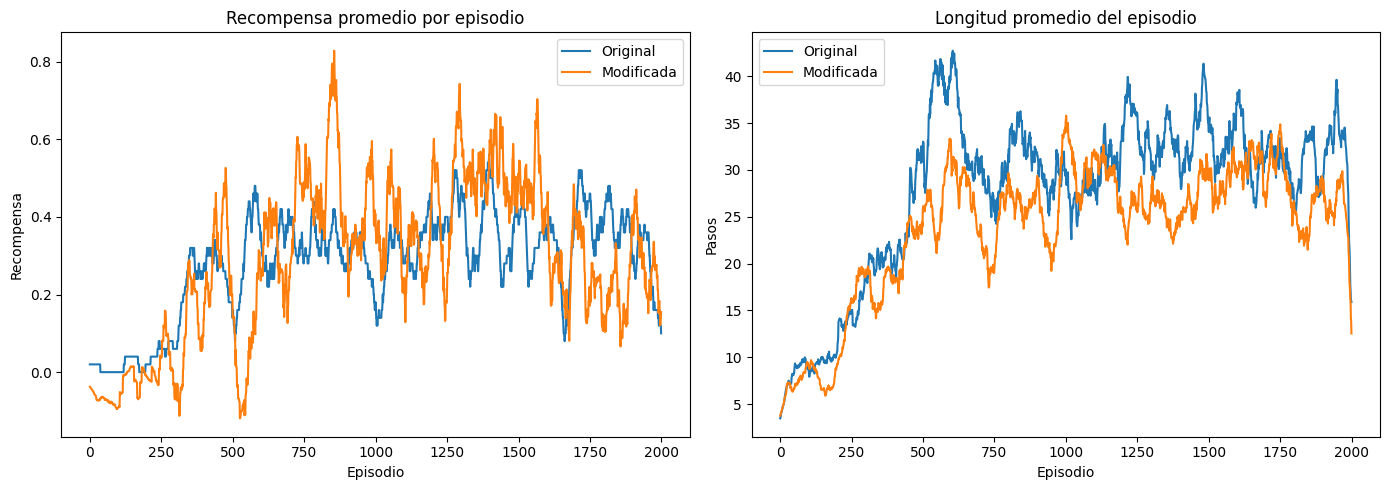

In [13]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros generales ---
env_name = "FrozenLake-v1"
env = gym.make(env_name, is_slippery=True)
n_states = env.observation_space.n
n_actions = env.action_space.n

N_EPISODES = 2000
MAX_STEPS = 100
ALPHA = 0.7
GAMMA = 0.99
EPSILON_INIT = 1.0
EPSILON_END = 0.05
EPSILON_RATE = 0.995

# --- Q-Learning con posibilidad de modificar la recompensa ---
def q_learning_custom_reward(
    env,
    n_episodes=N_EPISODES,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon_init=EPSILON_INIT,
    epsilon_end=EPSILON_END,
    epsilon_rate=EPSILON_RATE,
    step_penalty=0.0,                # Penalización por paso
    goal_reward=1.0                  # Recompensa al llegar al objetivo
):
    Q = np.zeros((n_states, n_actions))
    rewards = []
    episode_lengths = []
    epsilon = epsilon_init

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_length = 0
        done = False

        while not done and ep_length < MAX_STEPS:
            if np.random.rand() < epsilon:
                action = np.random.choice(n_actions)
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Modifica la recompensa aquí:
            mod_reward = reward
            if reward == 1.0:
                mod_reward = goal_reward
            mod_reward += step_penalty    # penalización por cada paso

            Q[state, action] += alpha * (mod_reward + gamma * np.max(Q[next_state]) - Q[state, action])

            state = next_state
            ep_reward += mod_reward
            ep_length += 1

        rewards.append(ep_reward)
        episode_lengths.append(ep_length)
        epsilon = max(epsilon_end, epsilon * epsilon_rate)

    return rewards, episode_lengths

def smooth(y, box_pts=50):
    y = np.array(y)
    box = np.ones(box_pts)/box_pts
    return np.convolve(y, box, mode='same')

# --- Entrena con estructura de recompensa original ---
rewards_orig, lens_orig = q_learning_custom_reward(env, step_penalty=0.0, goal_reward=1.0)

# --- Entrena con estructura de recompensa modificada ---
# Ejemplo: penalización -0.01 por paso y objetivo = 2.0
rewards_mod, lens_mod = q_learning_custom_reward(env, step_penalty=-0.01, goal_reward=2.0)

# --- Gráficos de comparación ---
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(smooth(rewards_orig), label='Original')
plt.plot(smooth(rewards_mod), label='Modificada')
plt.title('Recompensa promedio por episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.legend()

plt.subplot(1,2,2)
plt.plot(smooth(lens_orig), label='Original')
plt.plot(smooth(lens_mod), label='Modificada')
plt.title('Longitud promedio del episodio')
plt.xlabel('Episodio')
plt.ylabel('Pasos')
plt.legend()

plt.tight_layout()
plt.show()

* Modificar la estructura de recompensa (por ejemplo, penalizando cada paso y/o aumentando la recompensa al objetivo) motiva al agente a encontrar soluciones más rápidas y eficientes.
* El agente con recompensa modificada aprende estrategias que maximizan su recompensa total, lo que normalmente se traduce en episodios más cortos y con mayor probabilidad de éxito.
* La variabilidad de la recompensa aumenta, pero el desempeño promedio mejora.